# Modules

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
import time
import math
import glob
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors

sys.path.append('/kaggle/input/pythonutils')
from Metrics import *

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
from keras.layers import Conv1D, Bidirectional, Flatten, Reshape, GRU, Dense, Activation, Dropout, LSTM, MaxPooling1D, Input 
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, load_model, Model 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau ,EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l1

from sklearn.preprocessing import StandardScaler



# Preprocessing Data

In [2]:
from Preprocessing import create_house_dataframe, date

dataset_path='/kaggle/input/redd-dataset/REDD-20240715T094421Z-001/REDD'
house_list = [1,2,3,4,5,6]
df = create_house_dataframe(dataset_path , house_list)
dates = date(house_list, df)

House 1 finish:
                     mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-04-18 13:22:13          0.0               34.0               21.0   
2011-04-18 13:22:16          0.0               34.0               21.0   
2011-04-18 13:22:20          0.0               34.0               22.0   
2011-04-18 13:22:23          1.0               35.0               21.0   
2011-04-18 13:22:26          0.0               34.0               21.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-04-18 13:22:13        81.0   

In [10]:
house1=df[1].copy()
house2=df[2].copy()
house3=df[3].copy()
house4=df[4].copy()
house5=df[5].copy()
house6=df[6].copy()
houses=[house1,house2,house3,house4,house5,house6]

In [11]:
for house in houses :    
    house['aggregate']=house['mains_1']+house['mains_2']
    house.drop(columns=['mains_1','mains_2'], inplace=True )
    columns = ['aggregate'] + [col for col in house.columns.values[:-1]]
    house = house[columns]
#     print(house)

In [12]:
for i in [1,2,3,4,5,6]:
    print(df[i].columns.values)

['mains_1' 'mains_2' 'oven_3' 'oven_4' 'refrigerator_5' 'dishwaser_6'
 'kitchen_outlets_7' 'kitchen_outlets_8' 'lighting_9' 'washer_dryer_10'
 'microwave_11' 'bathroom_gfi_12' 'electric_heat_13' 'stove_14'
 'kitchen_outlets_15' 'kitchen_outlets_16' 'lighting_17' 'lighting_18'
 'washer_dryer_19' 'washer_dryer_20']
['mains_1' 'mains_2' 'kitchen_outlets_3' 'lighting_4' 'stove_5'
 'microwave_6' 'washer_dryer_7' 'kitchen_outlets_8' 'refrigerator_9'
 'dishwaser_10' 'disposal_11']
['mains_1' 'mains_2' 'outlets_unknown_3' 'outlets_unknown_4' 'lighting_5'
 'electronics_6' 'refrigerator_7' 'disposal_8' 'dishwaser_9' 'furance_10'
 'lighting_11' 'outlets_unknown_12' 'washer_dryer_13' 'washer_dryer_14'
 'lighting_15' 'microwave_16' 'lighting_17' 'smoke_alarms_18'
 'lighting_19' 'bathroom_gfi_20' 'kitchen_outlets_21' 'kitchen_outlets_22']
['mains_1' 'mains_2' 'lighting_3' 'furance_4' 'kitchen_outlets_5'
 'outlets_unknown_6' 'washer_dryer_7' 'stove_8' 'air_conditioning_9'
 'air_conditioning_10' 'misc

# Fridge

## Prep

In [13]:
def search_for_appliance(appliance_name):
    houses={}
    for i in [1,2,3,4,5,6]:
        house=df[i]
        exist = [ appliance for appliance in house.columns.values if appliance.startswith(appliance_name)]
        if exist: 
            houses[f"house{i}"]=[appliance for appliance in exist ]
    return houses 

In [14]:
search_for_appliance('refrig')

{'house1': ['refrigerator_5'],
 'house2': ['refrigerator_9'],
 'house3': ['refrigerator_7'],
 'house5': ['refrigerator_18'],
 'house6': ['refrigerator_8']}

In [15]:
# # Only houses that has the refrigerator appliance 
# X1 = df[1]['mains_1'].values.astype(np.float32)
# y1 = df[1]['refrigerator_5'].values.astype(np.float32)
# X2 = df[2]['mains_2'].values.astype(np.float32)
# y2 = df[2]['refrigerator_9'].values.astype(np.float32)
# X3 = df[3]['mains_2'].values.astype(np.float32)
# y3 = df[3]['refrigerator_7'].values.astype(np.float32)
# X5 = df[5]['mains_2'].values.astype(np.float32)
# y5 = df[5]['refrigerator_18'].values.astype(np.float32)
# X6 = df[6]['mains_2'].values.astype(np.float32)
# y6 = df[6]['refrigerator_8'].values.astype(np.float32)

# Only houses that has the refrigerator appliance 
X1 = house1['aggregate'].values.astype(np.float32)
y1 = house1['refrigerator_5'].values.astype(np.float32)
X2 = house2['aggregate'].values.astype(np.float32)
y2 = df[2]['refrigerator_9'].values.astype(np.float32)
X3 = house3['aggregate'].values.astype(np.float32)
y3 = df[3]['refrigerator_7'].values.astype(np.float32)
X5 = house5['aggregate'].values.astype(np.float32)
y5 = df[5]['refrigerator_18'].values.astype(np.float32)
X6 = house6['aggregate'].values.astype(np.float32)
y6 = df[6]['refrigerator_8'].values.astype(np.float32)

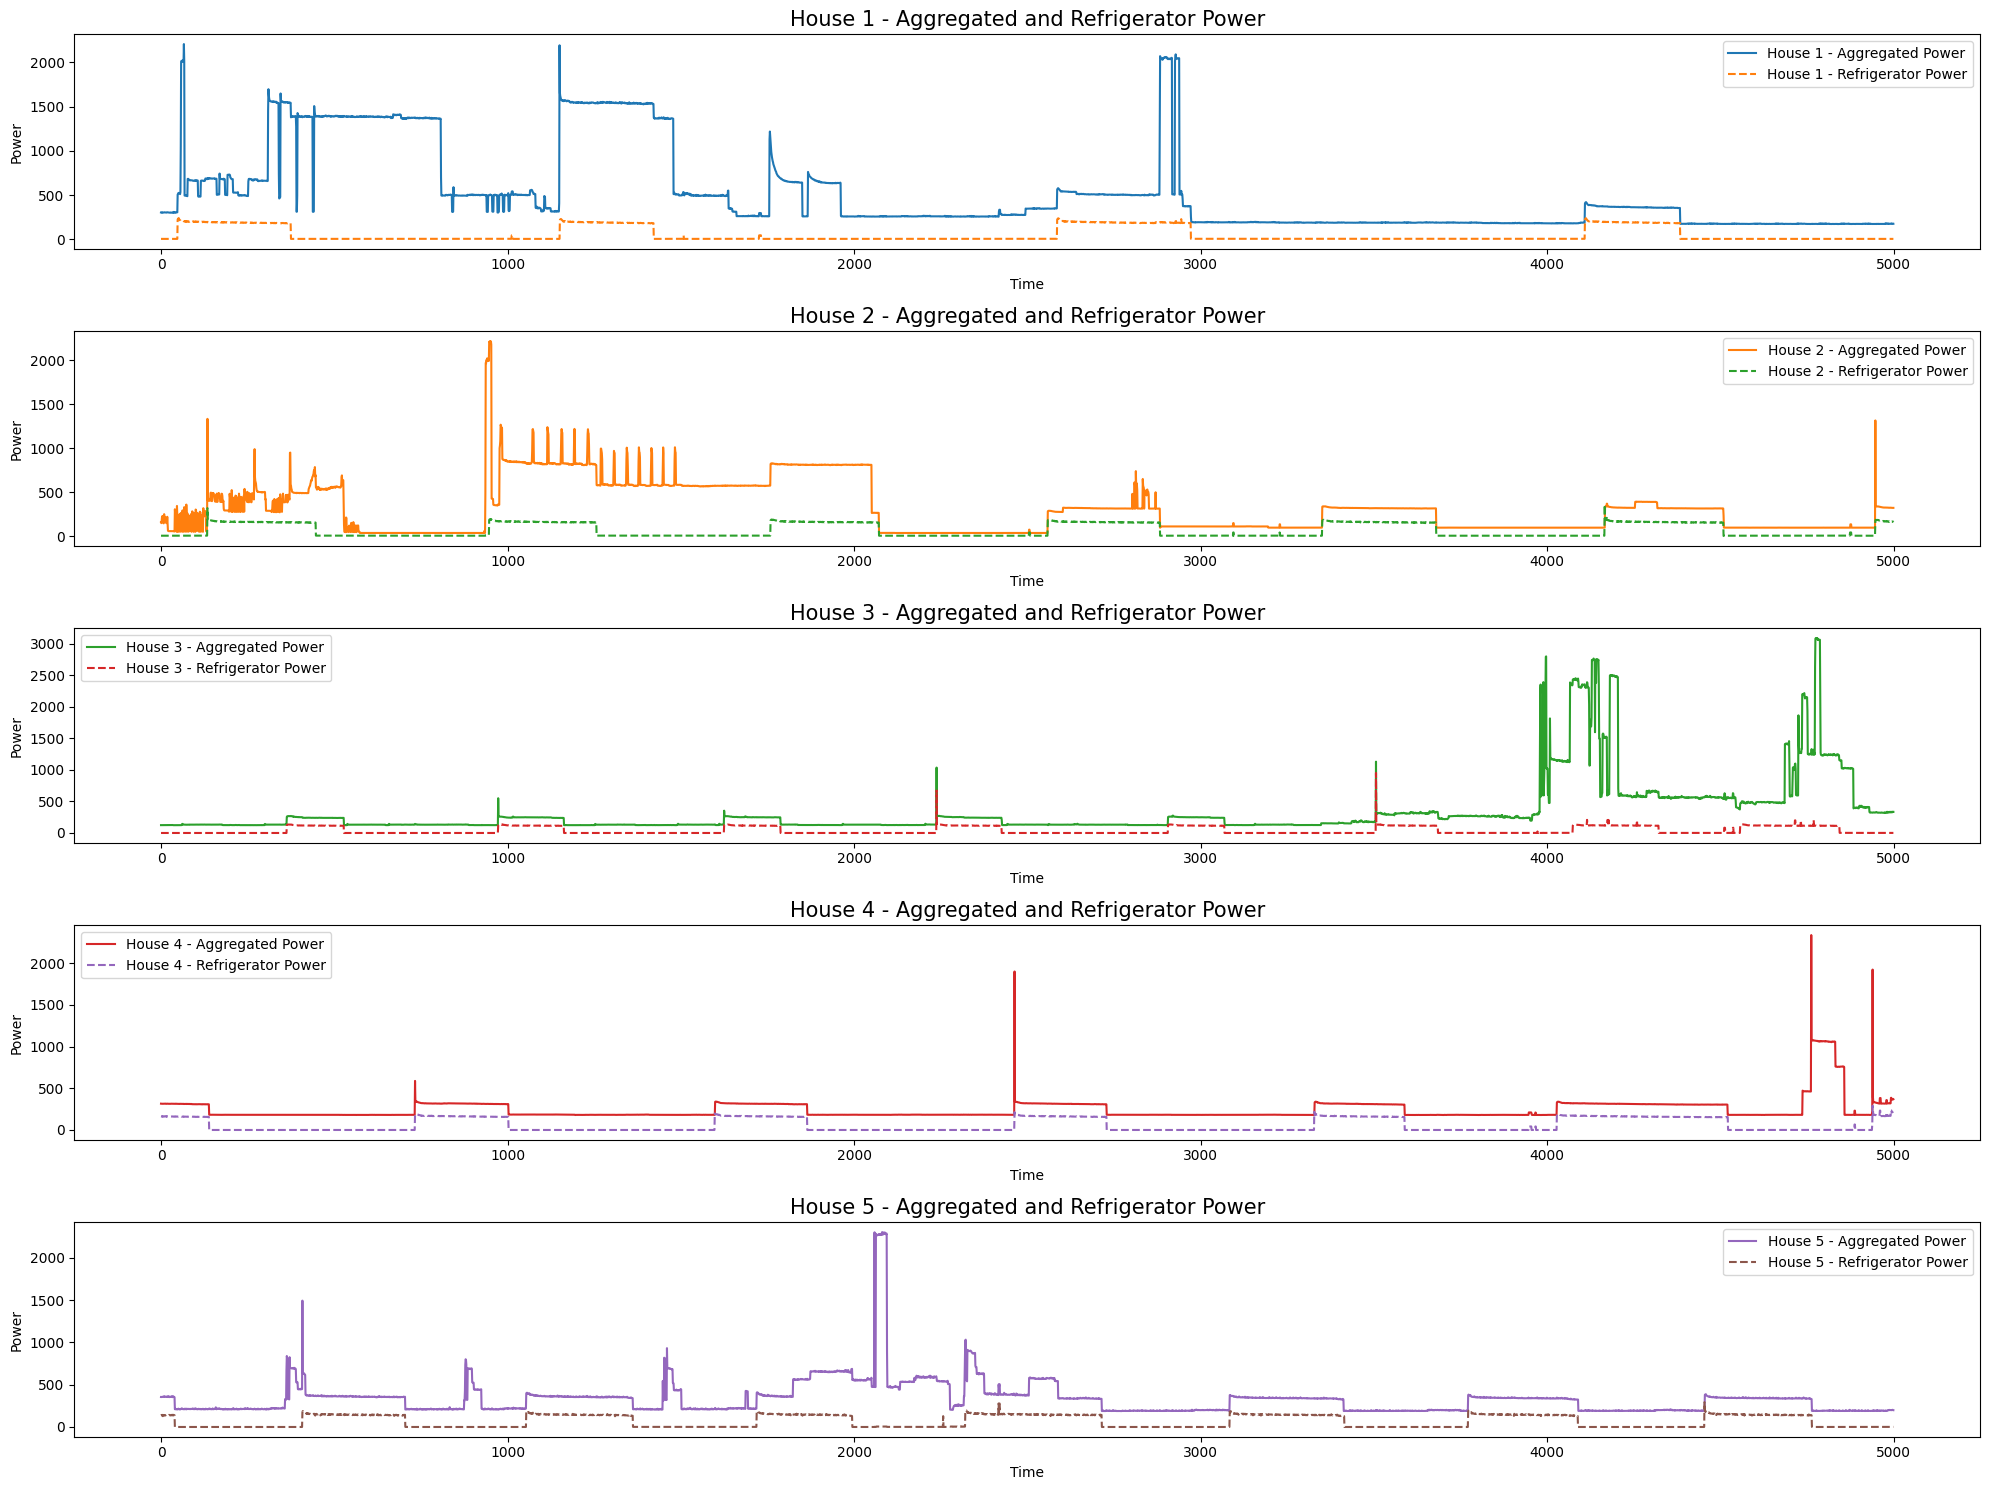

In [16]:
X_list = [X1, X2, X3, X5, X6]  # Aggregated power for each house
y_list = [y1, y2, y3, y5, y6]  # Refrigerator power for each house
fig, axes = plt.subplots(len(X_list), 1, figsize=(20, 15)) 

for i, (X,y)  in enumerate(zip(X_list,y_list)):
    ax = axes[i] 
    ax.plot(X[10000:15000], color=f"C{i}", label=f'House {i+1} - Aggregated Power')
    ax.plot(y[10000:15000], linestyle='--', color=f"C{i+1}", label=f'House {i+1} - Refrigerator Power')
    
    ax.set_title(f'House {i+1} - Aggregated and Refrigerator Power', fontsize=15)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

### Using X_d and X_dd // y_d

In [ ]:
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_ = []
    for i,value in enumerate(y):
      
        if i == 0 or i==len(y)-1:
            y_.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+1]>right_threshold:
#                        print('index:',i)
                y_.append(y[i+1]+1)
            else:
                y_.append(y[i])
    return np.array(y_)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d) # shape = (samples,)
    return X_d

def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    
    X_o = remove_abnormal_points(X_o)  # 去除异常点
    X_o = X_o/MAX_X # (samples,1)
    X_d = get_differential_sequence(X_o)  # (samples,)
    X_dd = get_differential_sequence(X_d) # (samples,)
            
    y_o = remove_abnormal_points(y_o)  # 去除异常点
    y_o = y_o/MAX_y # (samples,1)
    y_d = get_differential_sequence(y_o)  # (samples,)
            
    X = np.expand_dims(X_o,1)  # (samples,3)
    y = np.expand_dims(y_o,1)       # (samples,3)
            
    return X,y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
        X is X_o-X_d-X_dd  shape = (samples,3)
        y is y_o-y_d       shape = (samples,2)
    '''
    
    X_o_seg = [] 
    X_d_seg = []
    X_dd_seg = []
    
    y_o_seg = []
    y_d_seg = []
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
            X_d_seg.append(  X[i:i+seg_length,1] )
            X_dd_seg.append( X[i:i+seg_length,2] )

            y_o_seg.append(  y[i+seg_length//2-1,0] )
            y_d_seg.append(  y[i+seg_length//2-1,1] )
            
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg))
#     (segments,seg_length)
    return [np.array(X_o_seg,dtype = np.float32),np.array(X_d_seg), np.array(X_dd_seg)] ,  [np.array(y_o_seg),np.array(y_d_seg)]


### Without X_d and X_dd // y_d

In [17]:
# This function removes abnormal points
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_ = []
    for i,value in enumerate(y):
      
        if i == 0 or i==len(y)-1:
            y_.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+1]>right_threshold:
                y_.append(y[i+1]+1)
            else:
                y_.append(y[i])
    return np.array(y_)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d)
    return X_d

# Normalization 
def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    
    X_o = remove_abnormal_points(X_o)  
    X_o = X_o/MAX_X 
            
    y_o = remove_abnormal_points(y_o) 
    y_o = y_o/MAX_y 
            
    X = np.expand_dims(X_o,1)  
    y = np.expand_dims(y_o,1) 
            
    return X,y 

def standard_scaler(X,y):
    sc=StandardScaler()
    X = sc.fit_transform(pd.DataFrame(X))
    y = sc.fit_transform(pd.DataFrame(y))
    return X , y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
    X is X_o-X_d-X_dd  shape = (samples,3)
    y is y_o-y_d       shape = (samples,2)
    '''
    X_o_seg = []
    y_o_seg = []
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
            y_o_seg.append(  y[i+seg_length//2 -1,0] )
            
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg))
    
    return np.array(X_o_seg), np.array(y_o_seg)       #,np.array(X_d_seg), np.array(X_dd_seg)], [np.array(y_o_seg)],np.array(y_d_seg)]


In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1),(X3, y3),(X5, y5),(X6, y6)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X2, y2, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)

X_test = X_i  
y_test = y_i  

X_test_seg = X_seg_i 
y_test_seg = y_seg_i

In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, (int(len(X_train_tru) / windows_length), windows_length, 1))
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

## GRU

In [ ]:
pred= model.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 600)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[10000:30000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[10000:30000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()


# Light

In [10]:
search_for_appliance('light')

{'house1': ['lighting_9', 'lighting_17', 'lighting_18'],
 'house2': ['lighting_4'],
 'house3': ['lighting_5',
  'lighting_11',
  'lighting_15',
  'lighting_17',
  'lighting_19'],
 'house4': ['lighting_3', 'lighting_13', 'lighting_18', 'lighting_19'],
 'house5': ['lighting_4',
  'lighting_14',
  'lighting_17',
  'lighting_19',
  'lighting_23'],
 'house6': ['lighting_14']}

## Prep

In [45]:
X1 = df[1]['mains_1'].values.astype(np.float32)
y10 = df[1]['lighting_9'].values.astype(np.float32)
y11 = df[1]['lighting_17'].values.astype(np.float32)
y12 = df[1]['lighting_18'].values.astype(np.float32)
y1_all=y10+y11+y12

X2 = df[2]['mains_2'].values.astype(np.float32)
y2 = df[2]['lighting_4'].values.astype(np.float32)

X3 = df[3]['mains_2'].values.astype(np.float32)
y30 = df[3]['lighting_11'].values.astype(np.float32)
y31 = df[3]['lighting_15'].values.astype(np.float32)
y32 = df[3]['lighting_17'].values.astype(np.float32)
y33 = df[3]['lighting_19'].values.astype(np.float32)
y3_all=y30+y31+y32+y33

X4 = df[4]['mains_1'].values.astype(np.float32)
y40 = df[4]['lighting_3'].values.astype(np.float32)
y41 = df[4]['lighting_13'].values.astype(np.float32)
y42 = df[4]['lighting_18'].values.astype(np.float32)
y43 = df[4]['lighting_19'].values.astype(np.float32)
y4_all=y40+y41+y42+y43


X5 = df[5]['mains_1'].values.astype(np.float32)
y50 = df[5]['lighting_4'].values.astype(np.float32)
y51 = df[5]['lighting_14'].values.astype(np.float32)
y52 = df[5]['lighting_17'].values.astype(np.float32)
y53 = df[5]['lighting_19'].values.astype(np.float32)
y54 = df[5]['lighting_23'].values.astype(np.float32)
y5_all=y50+y51+y52+y53+y54

# X6 = df[6]['mains_2'].values.astype(np.float32)
# y6 = df[5]['lighting_14'].values.astype(np.float32) ## Low consumption 

In [43]:
X_list = [X1, X2, X3, X4, X5]  # Aggregated power for each house
y_list = [y1_all, y2, y3_all, y4_all, y5_all]  # lights power for each house

for i ,(X,y) in enumerate (zip(X_list,y_list)):
    print(f'====== House {i+1} ============')
    print(f'X{i+1}',pd.DataFrame(X).describe())
    print(f'y{i+1}',pd.DataFrame(y).describe())

====== House 1 ============
X1                    0
count  406748.000000
mean      227.353119
std       409.695435
min        51.869999
25%        92.120003
50%       130.380005
75%       234.460007
max      6081.359863
y1                    0
count  406748.000000
mean       74.649628
std        64.170265
min         0.000000
25%         4.000000
50%        82.000000
75%        85.000000
max       421.000000
====== House 2 ============
X2                    0
count  316840.000000
mean      187.440964
std       215.064148
min        21.280001
25%        22.469999
50%       218.375000
75%       259.130005
max      3149.020020
y2                    0
count  316840.000000
mean       26.607622
std        45.920616
min         0.000000
25%         8.000000
50%         8.000000
75%         9.000000
max       289.000000
====== House 3 ============
X3                    0
count  376150.000000
mean      211.226059
std       373.499420
min         0.160000
25%        16.372500
50%       129.72000

In [ ]:
X=X5
y=y54
plt.rcParams["figure.figsize"] = [20,9]
plt.plot((X), color = 'C0', label = 'Aggregated Power')
plt.plot((y), color = 'C3', label = 'Light Power')
plt.legend()
pd.DataFrame(y).describe()

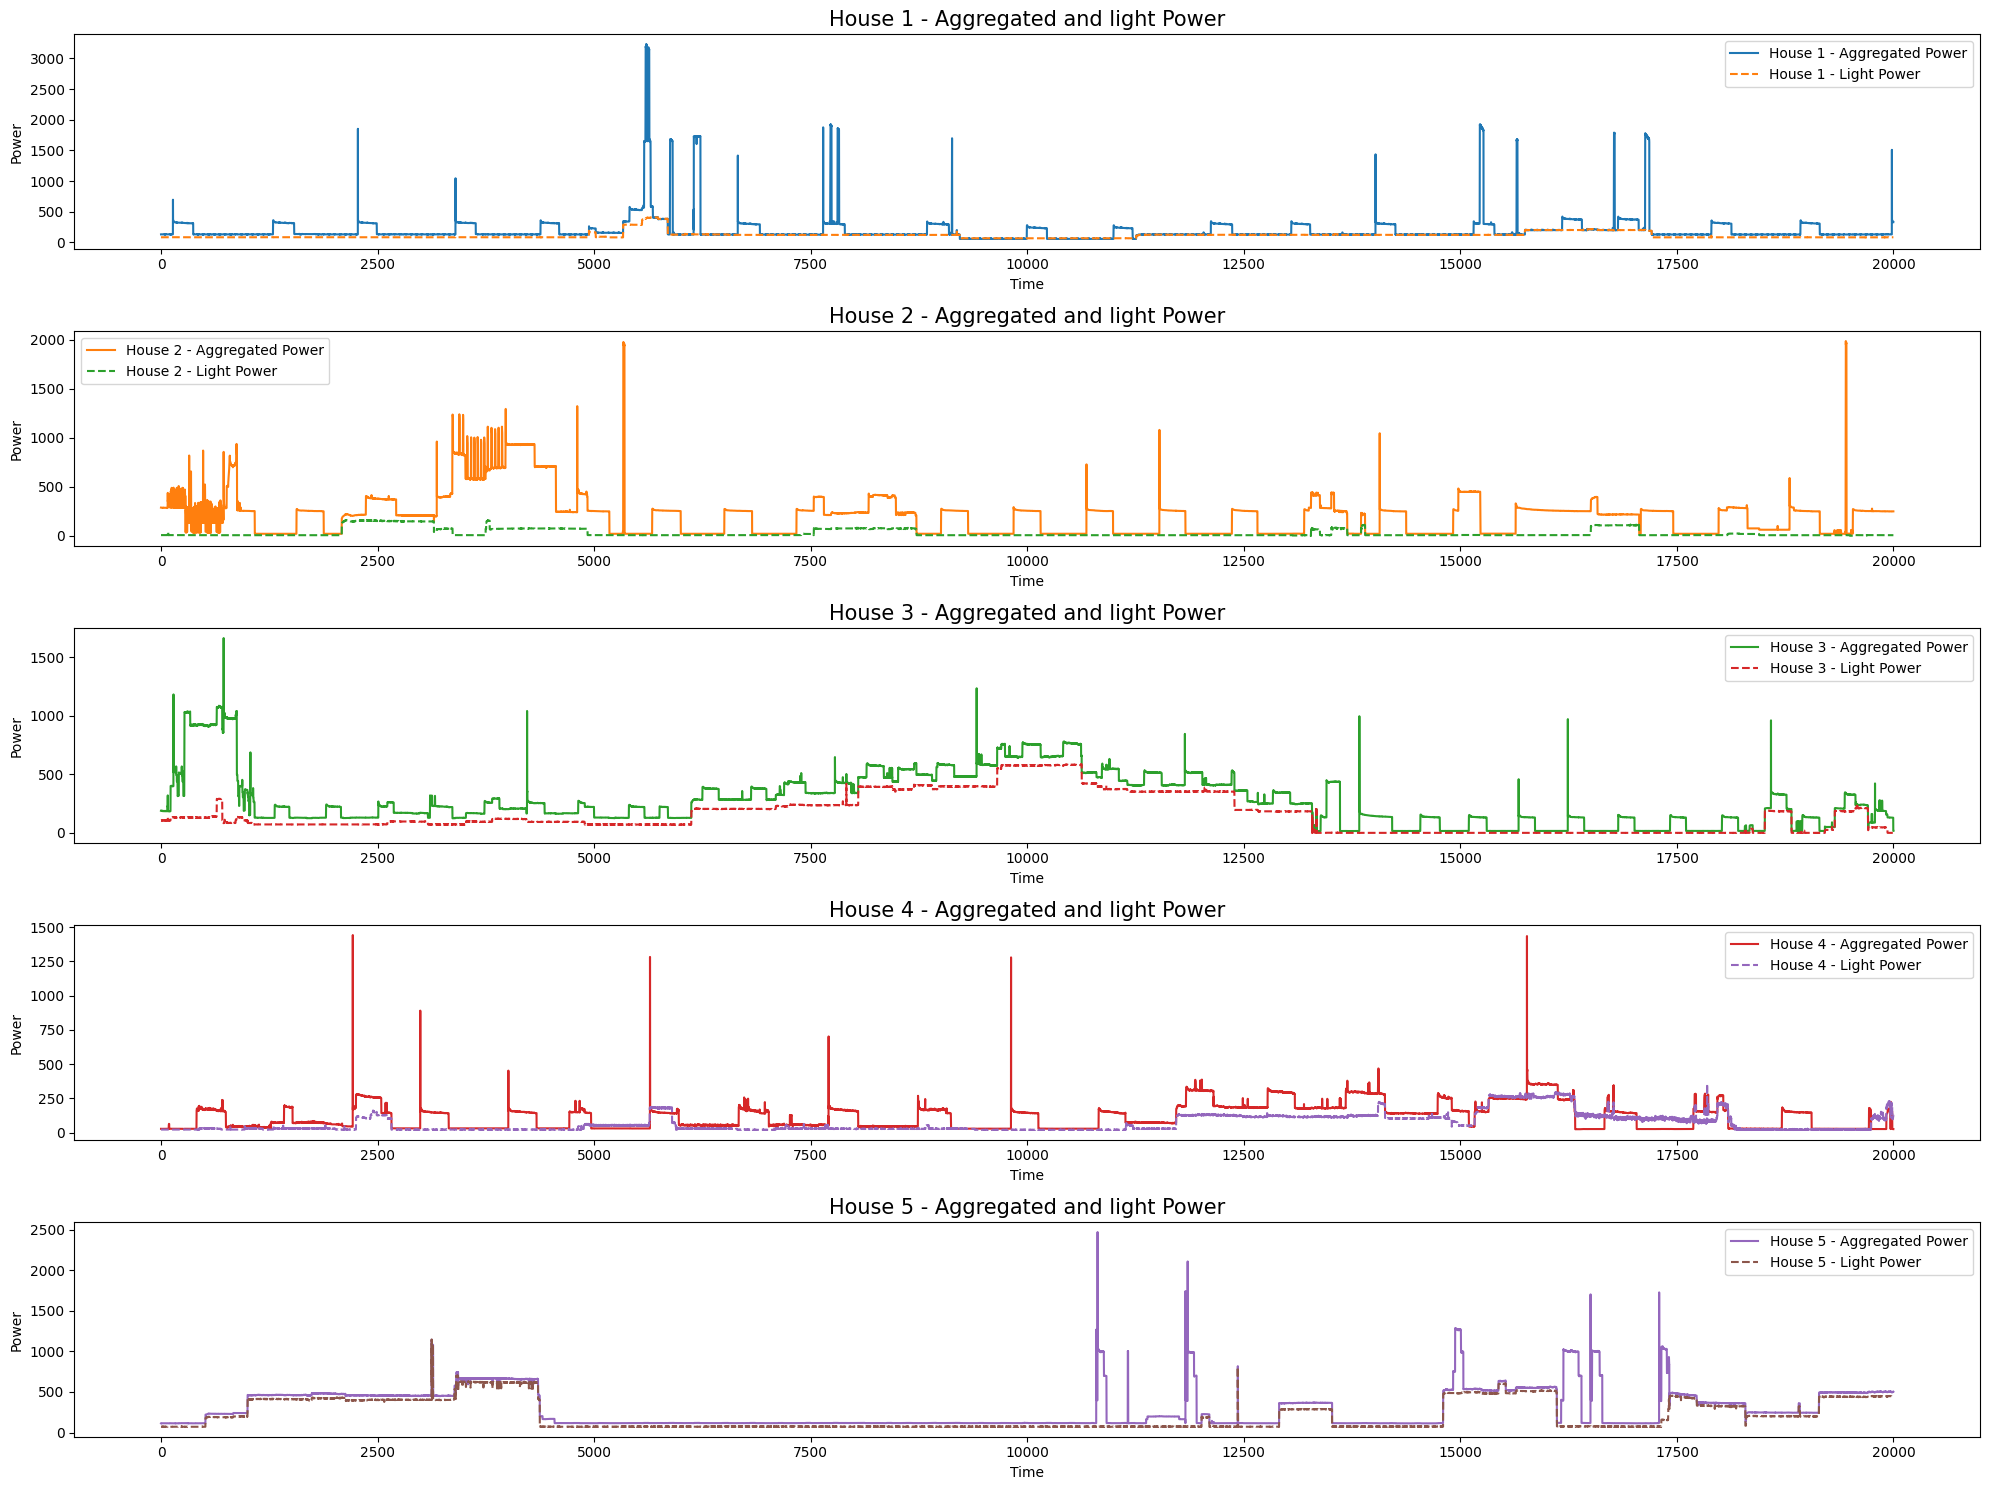

In [46]:
fig, axes = plt.subplots(len(X_list), 1, figsize=(20, 15)) 

for i, (X,y)  in enumerate(zip(X_list,y_list)):
    ax = axes[i] 
    ax.plot(X[15000:35000], color=f"C{i}", label=f'House {i+1} - Aggregated Power')
    ax.plot(y[15000:35000], linestyle='--', color=f"C{i+1}", label=f'House {i+1} - Light Power')

    ax.set_title(f'House {i+1} - Aggregated and light Power', fontsize=15)
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [49]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1_all),(X2, y2),(X3, y3_all),(X5, y5_all)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        
        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

-------- Load Training Data ---------
        sequence length = 406748
        windows length = 50
        stride = 1
        segments = 406699
(406699, 50) (406699,)
        sequence length = 316840
        windows length = 50
        stride = 1
        segments = 316791
(316791, 50) (316791,)
        sequence length = 376150
        windows length = 50
        stride = 1
        segments = 376101
(376101, 50) (376101,)
        sequence length = 77451
        windows length = 50
        stride = 1
        segments = 77402
(77402, 50) (77402,)


In [50]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [51]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X4, y4_all, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

-------- Load Testing Data ---------
        sequence length = 428076
        windows length = 50
        stride = 1
        segments = 428027


In [52]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))


X_train.shape = (1177189, 1)
y_train.shape = (1177189, 1)
X_o_train_seg.shape = (1176993, 50)
y_o_train_seg.shape = (1176993,)

X_test.shape = (428076, 1)
y_test.shape = (428076, 1)
X_o_test_seg.shape = (428027, 50)
y_o_test_seg.shape = (428027,)


In [53]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

X_o_train_seg.shape = (1176993, 50, 1)
y_o_train_seg.shape = (1176993,)
X_o_test_seg.shape = (428027, 50, 1)
y_o_test_seg.shape = (428027,)


In [23]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, ( int(len(X_train_tru) / windows_length), windows_length, 1 ) )
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

(1527800, 1) (1527800, 1) (77400, 1) (77400, 1)
(30556, 50, 1) (30556, 50, 1) (1548, 50, 1) (1548, 50, 1)


## GRU

In [ ]:
# Load lights model 

In [ ]:
pred= model.predict(X_train_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y, 10)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[50000:80000], color = 'C0',label = 'Predicted value')
plt.plot((y_train_seg*MAX_y)[50000:80000], color = 'C3', label = 'True Value')
plt.legend()
plt.title('Power generated in 2021(lighter) and 2020(darker)',fontsize=25)
plt.ylabel('Generated Power(kW)', fontsize=20)
# plt.savefig('.\\New folder\\lCONV.png')

# Microwave

In [ ]:
search_for_appliance('microwave')

## Prep

In [ ]:
X1 = df[1]['mains_1'].values.astype(np.float32)
y1 = df[1]['microwave_11'].values.astype(np.float32)
X2 = df[2]['mains_2'].values.astype(np.float32)
y2 = df[2]['microwave_6'].values.astype(np.float32)
X3 = df[3]['mains_1'].values.astype(np.float32)
y3 = df[3]['microwave_16'].values.astype(np.float32)
X5 = df[5]['mains_2'].values.astype(np.float32)
y5 = df[5]['microwave_3'].values.astype(np.float32)

In [ ]:
figure = plt.figure(figsize=(20,8))
plt.plot((X3)[6000:9000], color = 'red', alpha = 0.6, label = 'Aggregated Power')
plt.plot((y3)[6000:9000], color = 'blue', alpha = 0.6, label = 'Microwave Power')
plt.legend()

In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 100
stride = 1

for X,y in [(X5, y5),(X2, y2),(X3, y3)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        

        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X1, y1, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, (int(len(X_train_tru) / windows_length), windows_length, 1))
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

## GRU

In [ ]:
# # MIght take 6 min to run

# # model_CONV1D = load_model("/content/drive/My Drive/EEE312/Microwave_S2P_w50_5Epoch.h5")
# pred= new_model1.predict(X_test_seg)

# mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# print('Mean square error on test set: ', mse_loss_norm)
# print('Mean absolute error on the test set: ', mae_loss_norm)

# rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
# rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))

# print("============ Relative error in total energy: {}".format(rete))
# print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[15000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[15000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

# Building Model

## TPU

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if TPU is not available
print("REPLICAS: ", strategy.num_replicas_in_sync)


In [54]:
def create_model(time_stamp):

    model = Sequential()
    # 1D Conv
    model.add(Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=(time_stamp,1)))
    model.add(Conv1D(8, 4, activation="relu", padding="same", strides=1))

    # Bi-directional LSTMs
    model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Bidirectional(GRU(128, return_sequences=False, stateful=False), merge_mode='concat'))

    # Fully Connected Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    opt = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt)

    return model

# with tpu_strategy.scope():
#     model = create_model(windows_length)


In [55]:
# with strategy.scope():  ## use with tpu 
appliance='lights'
model = create_model(windows_length)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 16)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 8)          │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,673 (951.85 KB)

 Trainable params: 243,673 (951.85 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
ckpt = ModelCheckpoint(filepath=f"/kaggle/working/best_GRU_{appliance}.keras", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, mode='min', verbose=1)

In [ ]:
# with strategy.scope():  ##use with tpu 
    
# BATCH_SIZE = 64 * strategy.num_replicas_in_sync  #

history = model.fit(
    X_train_seg, 
    y_train_seg, 
    epochs=30,
    batch_size=64, 
    validation_split=0.01 ,
#     validation_data=(X_auto_test, y_auto_test),
    shuffle=True,
    callbacks=[ckpt, reduce_lr, early_stopping]
)

# Load the best model and save it
model = load_model(f"/kaggle/working/best_GRU_{appliance}.keras")
model.save(f"/kaggle/working/best_GRU_{appliance}.h5")


Epoch 1/30
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1135
Epoch 1: val_loss improved from inf to 0.13511, saving model to /kaggle/working/best_GRU_lights.keras
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 243s 13ms/step - loss: 0.1135 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 2/30
18204/18207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0784
Epoch 2: val_loss improved from 0.13511 to 0.08447, saving model to /kaggle/working/best_GRU_lights.keras
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 237s 13ms/step - loss: 0.0784 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 3/30
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0689
Epoch 3: val_loss improved from 0.08447 to 0.06901, saving model to /kaggle/working/best_GRU_lights.keras
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 234s 13ms/step - loss: 0.0689 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 4/30
18204/18207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0638
Epoch 4: val_loss improved from 0.06901 to 0.05617, saving model to /kaggle/work

In [ ]:
# history_i = new_model1.fit(X_train_seg, 
#                         y_train_seg, 
#                         epochs=5,
#                         batch_size=128, 
#                         validation_split=0.005,
#                                              validation_data=(X_test_seg[:i],
#                                                               y_test_seg[0]),
#                         shuffle=True,
#                         callbacks=[checkpointer])

## Visualising model performance 

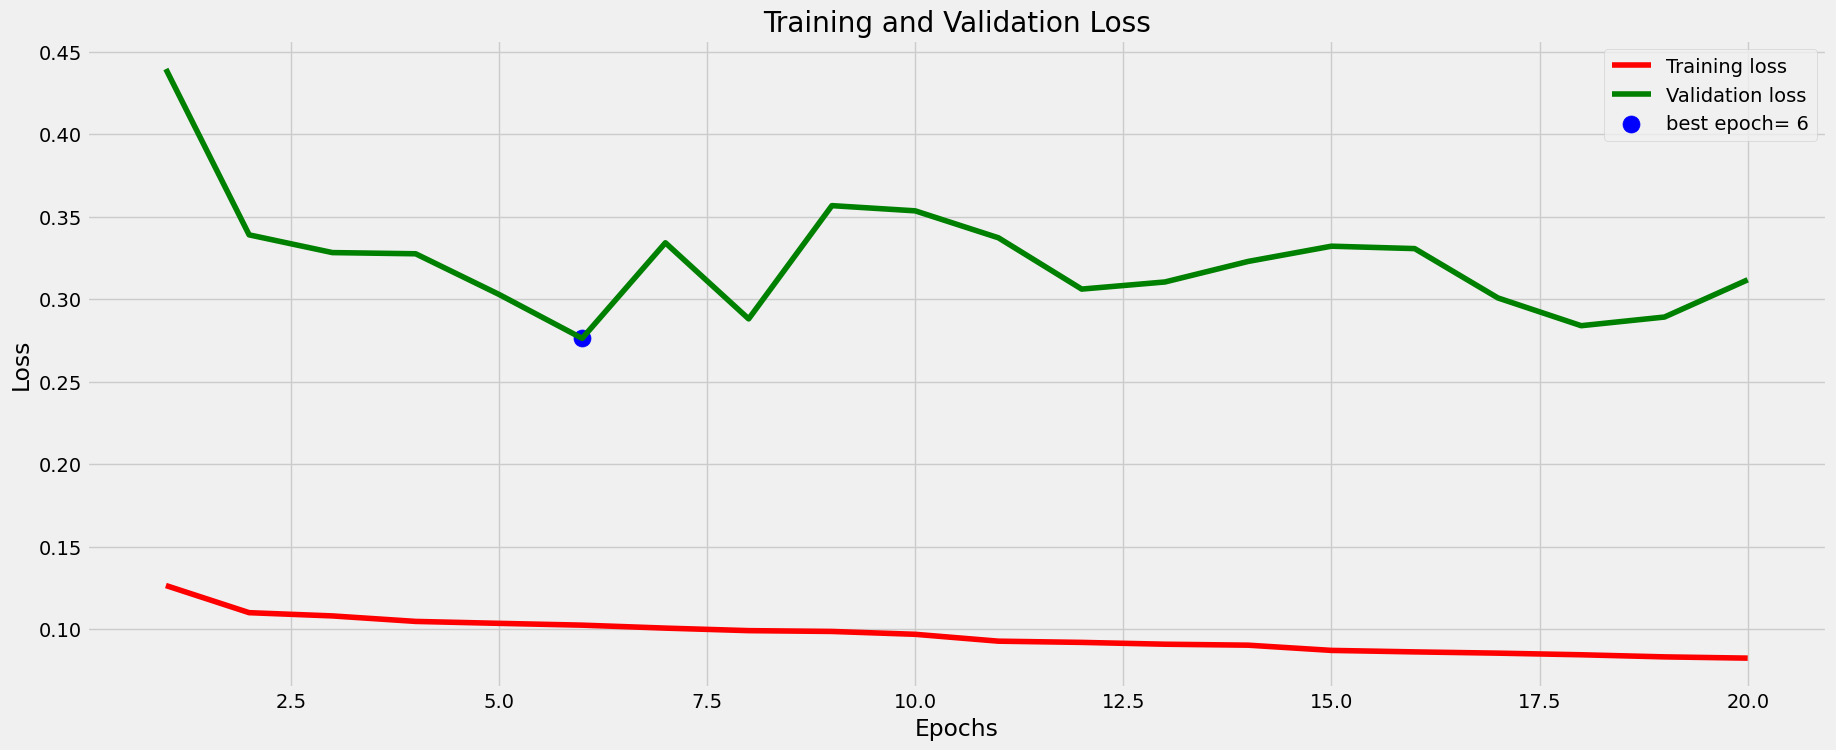

In [54]:
# Define needed variables
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

Epochs = [i+1 for i in range(len(tr_loss))]
loss_label = f'best epoch= {str(index_loss + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout
plt.show()

# Data Augmentation Using GANs

In [62]:
def create_gan_training_data(all_data, threshold=10, power_threshold=50):
    non_empty_batches = []
    for elem in all_data:
        for batch in elem:
            # Count values that exceed the specified power threshold
            count_above_threshold = np.sum(batch > power_threshold)
            if count_above_threshold >= threshold:
                non_empty_batches.append(batch)

    # Convert to numpy array for consistency
    non_empty_batches = np.array(non_empty_batches)
    
    return non_empty_batches


In [63]:
Y1=np.expand_dims(y1_all,1) 
light_consumption_windows1, _ = shift_segment(Y1,Y1,windows_length,stride,False)
print(light_consumption_windows1.shape)
Y2=np.expand_dims(y2,1) 
light_consumption_windows2, _ = shift_segment(Y2,Y2,windows_length,stride,False)
print(light_consumption_windows2.shape)
gan_data=create_gan_training_data((light_consumption_windows1,light_consumption_windows2))
print(gan_data.shape)

(8134, 50)
(6336, 50)
(6002, 50)


In [32]:
# Define Generator and Discriminator
def create_generator(input_dim, output_dim):
    generator = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh'),
        Reshape((output_dim, 1))  # Reshape to match (50, 1)
    ])
    return generator

def create_discriminator(input_dim):
    discriminator = Sequential([
        Flatten(input_shape=(input_dim, 1)),  # Flatten the input (50, 1) to (50,)
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

def train_gan(generator, discriminator, gan_model, data, epochs=1000, batch_size=64):
    data = data.reshape(-1, 50)  
    for epoch in range(epochs):
        # Randomly select real data
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = data[idx]
        real_labels = np.ones((batch_size, 1))
        
        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        fake_data = fake_data.reshape(batch_size, 50)  # Reshape to match discriminator input
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator on real and fake data
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))  # Labels for the generator (to fool the discriminator)
        g_loss = gan_model.train_on_batch(noise, valid_labels)
        
        # Display progress every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch} | D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}\n')
            print(f'D Acc: {d_loss_real[1]*100}%  real ')
            print(f'D Acc: {d_loss_fake[1]*100}%  fake ')



In [30]:
# Define GAN components (Generator and Discriminator)
def create_generator(input_dim, output_dim):
#     with strategy.scope():
    generator = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])

    return generator

def create_discriminator(input_dim):
#     with strategy.scope():
    discriminator = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

def train_gan(generator, discriminator, gan_model, data, epochs=1000, batch_size=64):
    for epoch in range(epochs):
        # Select random real data
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = data[idx]
        real_labels = np.ones((batch_size, 1))

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise, verbose)
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator on real and fake data
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan_model.train_on_batch(noise, valid_labels)

        # Display progress every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch} | D Loss: {d_loss_real[0]}, D Acc: {d_loss_real[1]*100}% | G Loss: {g_loss}')


In [33]:
# Initialize generator and discriminator
latent_dim = 50
# with strategy.scope():

generator = create_generator(latent_dim, X_train_seg.shape[1])
discriminator = create_discriminator(X_train_seg.shape[1])

# Compile discriminator
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

# Define GAN model
gan_input = Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan_model = Model(gan_input, gan_output)
gan_model.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# Train the GAN model
train_gan(generator, discriminator, gan_model, X_train_seg, epochs=1000, batch_size=64)


I0000 00:00:1730037754.310419     397 service.cc:145] XLA service 0x7f5edc007d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730037754.310485     397 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730037754.310491     397 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


I0000 00:00:1730037754.611252     397 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 | D Loss Real: 0.7090343236923218, D Loss Fake: 0.6543123126029968, G Loss: [array(0.6543123, dtype=float32), array(0.6543123, dtype=float32), array(0.4921875, dtype=float32)]

D Acc: 0.0%  real 
D Acc: 49.21875%  fake 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# Generate synthetic samples
num_synthetic_samples = 50000
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Append synthetic data to original training data
X_train_augmented = np.vstack([X_train_seg, synthetic_data])
y_train_augmented = np.hstack([y_train_seg, y_train_seg[:num_synthetic_samples]])  # Assuming label replication for simplicity

print('Original training data shape:', X_train_seg.shape)
print('Augmented training data shape:', X_train_augmented.shape)


In [ ]:
# Retraining the GRU model with augmented data

new_model=create_model(windows_length)

# Fit the GRU model on augmented data
new_model.fit(X_train_augmented, y_train_augmented, epochs=5, batch_size=64,  
#               validation_data=(X_test_seg, y_test_seg),
              validation_split=0.01 )

# Evaluate model performance on the test set
pred_augmented = new_model.predict(X_test_seg)
mse_loss_augmented = mse_loss(pred_augmented.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_augmented = mae_loss(pred_augmented.reshape(-1)*MAX_y, y_test_seg*MAX_y)


print('--- Results After Data Augmentation ---')
print('MSE:', mse_loss_augmented)
print('MAE:', mae_loss_augmented)
